---
<h3 align=center><strong><em>Emoji'on (Application de reconnaissance d'émotions)</em></strong></h3>

---

<h4><em>Dans ce projet, vous allez réaliser une application permettant de détecter le visages des personnes dans une capture vidéo (WEBCAM) et de le remplacer par un émoji en fonction de l'émotion correspondante.<br>
Le projet est réalisé sur googlecolab afin d'utiliser leur GPU et de bénéficier d'une puissance de calcul suffisante.
</em></h4>

---

<h4><em>Connection à google drive pour récupérer le fichier csv qui contient nos données</em></h4>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

data= pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

<h6>L'emotion disgust ne contient que 547 images. Donc nous pourra faire une data augmentation à l'aide d'imageDataGenerator() sur notre jeu d'entrainement</h6>

In [4]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

<h6> Notre jeu de données ne contient aucune valeur nulle.</h6>

<h3><em>Répartition de notre dataset :</em></h3>

In [5]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
emotion_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Disgust,547


In [7]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {} \nvalidation shape: {} \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3) 
validation shape: (3589, 3) 
test shape: (3589, 3)


In [8]:
# barplot class distribution of train, val and test
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("darkgrid")

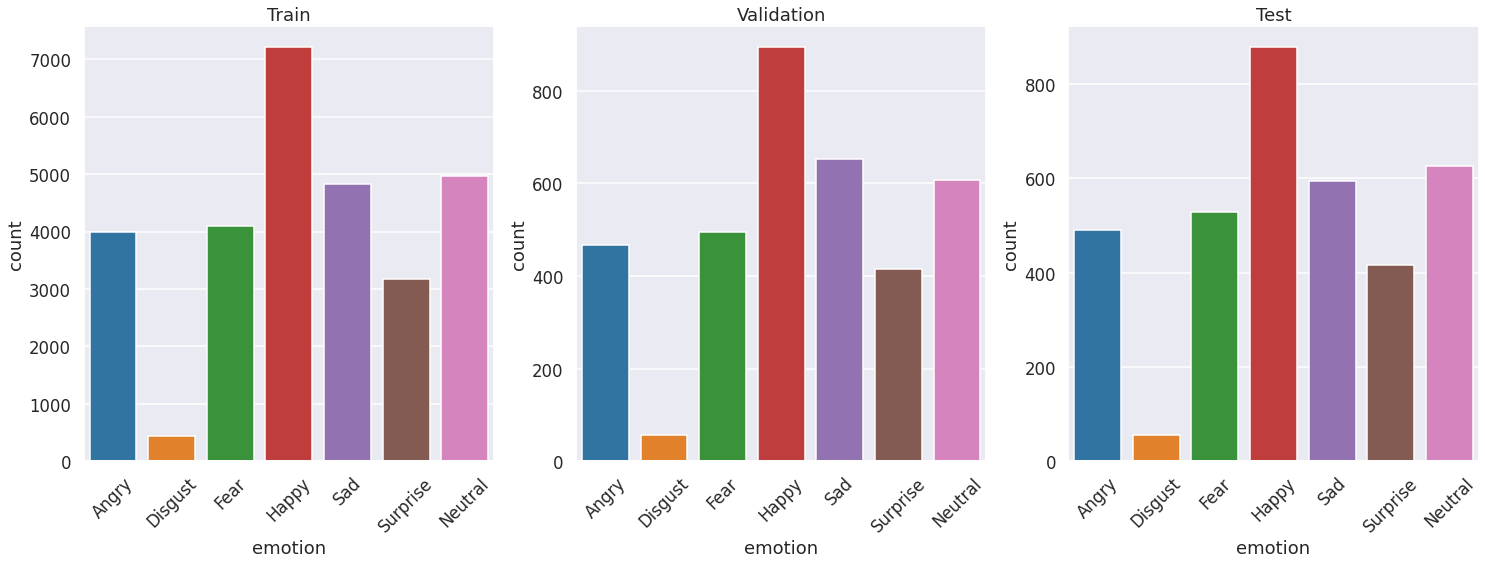

In [9]:
def affichage_datas():
  fig, ax = plt.subplots(1,3, figsize=(25,8))
  #TRAIN
  sns.countplot(x=data_train['emotion'],data=data_train,ax=ax[0])
  ax[0].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[0].set_title("Train")
  #VALIDATION
  sns.countplot(x=data_val['emotion'],data=data_val,ax=ax[1])
  ax[1].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[1].set_title("Validation")
  #TEST
  sns.countplot(x=data_test['emotion'],data=data_test, ax=ax[2])
  ax[2].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[2].set_title("Test")
  plt.show()
  return

affichage_datas()

In [10]:
import numpy as np
from numpy import expand_dims
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    horizontal_flip=True,
    brightness_range=[0.2,1.0]
)


def augmentation_data(data,emotion,multiplicateur):
    for index, row in data.iterrows():
        
        # code pour transformer chaque ligne en image
        if row[0]==emotion:
            to_array = [int(i) for i in row[1].split(" ")]
            to_image = np.reshape(to_array,(48,48))
        
        # Effectuer une transformation
            image_to_array = img_to_array(to_image)
            samples = expand_dims(image_to_array, 0)
            it = datagen.flow(samples, batch_size=1)
            for i in range(multiplicateur):
                batch = it.next()
                new_image = batch[0].astype('uint8')

            # Applatir la nouvelle image 
                new_image = new_image.ravel()
            
            # La transformer en string
                temp=""
                for i in range(0,len(new_image)):
                    temp += str(new_image[i])+" "
                
            # Concatener le resultat au dataframe
                df_temp= pd.DataFrame({'emotion': row[0], 'pixels': temp},index = [0])
                data = pd.concat([data, df_temp],ignore_index = True)
    return data

In [11]:
data_train= augmentation_data(data_train,1,6)


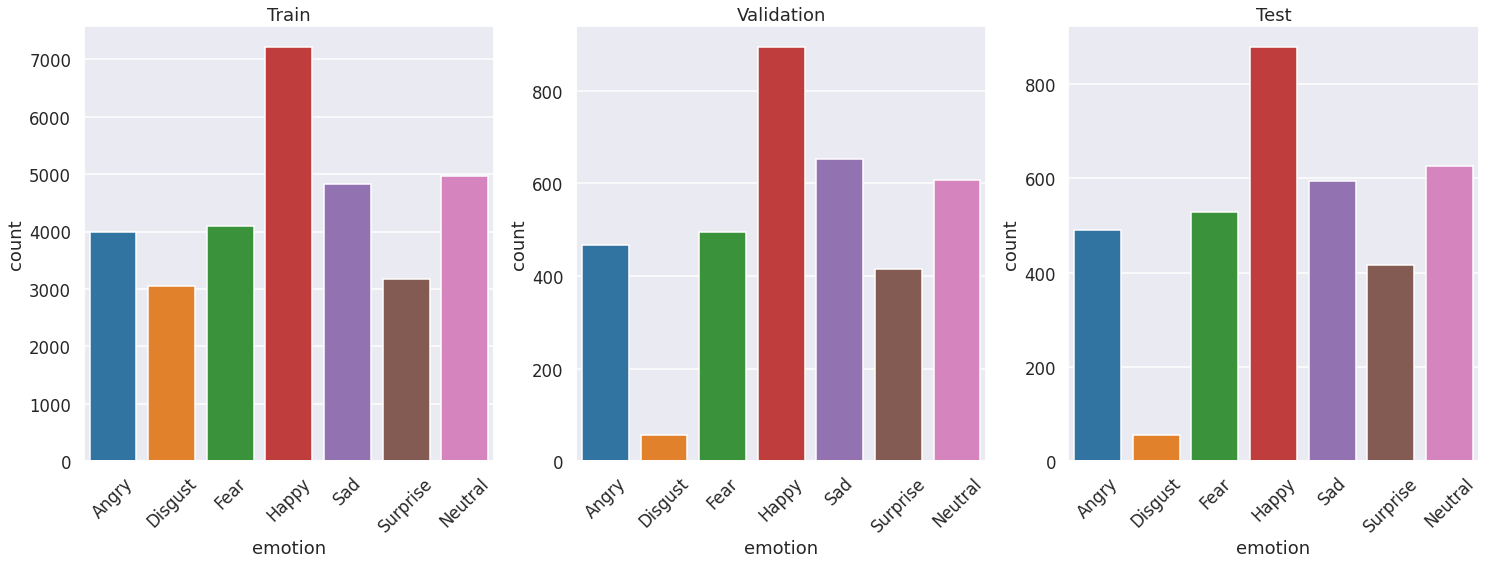

In [12]:
affichage_datas()

<h6>L'emotion disgust a bien été augmentée dans notre jeu d'entrainement</h6>

In [13]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

from keras.utils import to_categorical

num_classes = 7
height,width = 48, 48

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: (31325, 48, 48, 1),  train _Y shape: (31325, 7)
val _X shape: (3589, 48, 48, 1),  val _Y shape: (3589, 7)
test _X shape: (3589, 48, 48, 1),  test _Y shape: (3589, 7)


# Nouvelle section

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.layers import GaussianNoise

def config_model():
  model = Sequential()

  # 1st - Convolution Layer
  model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))

  # 2nd Convolution layer
  model.add(Conv2D(128,(5,5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))


  # 3rd Convolution layer
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))

  # 4th Convolution layer
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))

  # Flattening
  model.add(Flatten())

  # Fully connected layer : 1st layer
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.15))

  # Fully connected layer : 2st layer
  model.add(Dense(256))
  #model.add(BatchNormalization())
  model.add(GaussianNoise(0.1))
  model.add(Activation('relu'))
  model.add(Dropout(0.15))

  # Fully connected layer : 3rd layer
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.15))

  model.add(Dense(7, activation='softmax'))

  opt = Adam(lr=0.0005)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [15]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


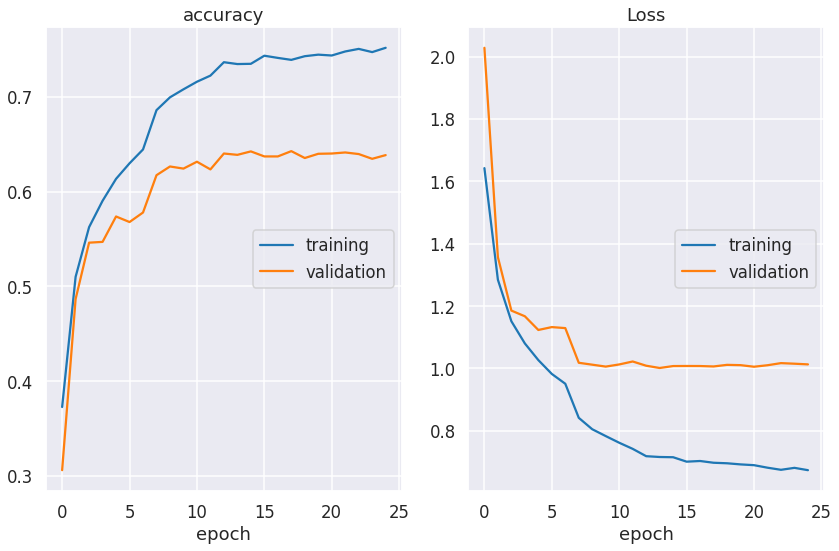

accuracy
	training         	 (min:    0.373, max:    0.752, cur:    0.752)
	validation       	 (min:    0.306, max:    0.643, cur:    0.638)
Loss
	training         	 (min:    0.674, max:    1.642, cur:    0.674)
	validation       	 (min:    1.001, max:    2.028, cur:    1.013)

Epoch 25: saving model to model_weights.h5
489/489 [==============================] - 17s 34ms/step - loss: 0.6736 - accuracy: 0.7516 - val_loss: 1.0129 - val_accuracy: 0.6384 - lr: 1.0000e-05


In [16]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF


def train_model(model):
  img_size = 48
  batch_size = 64


  datagen_train = ImageDataGenerator(horizontal_flip=True)
  train_generator = datagen_train.flow(train_X, train_Y,
                                                      batch_size=batch_size,
                                                      shuffle=True)

  datagen_validation = ImageDataGenerator(horizontal_flip=True)
  validation_generator = datagen_validation.flow(val_X, val_Y,
                                                      batch_size=batch_size)

  epochs = 25
  steps_per_epoch = train_generator.n//train_generator.batch_size
  validation_steps = validation_generator.n//validation_generator.batch_size

  # Reducing Learning Rate
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=2, min_lr=0.00001, mode='auto')
  # Recuperation des poids qui ont le meilleurs score sur la validation
  checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                              save_weights_only=True, mode='max', verbose=1)
  
  

  # Training the Model
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps,
      callbacks=[PlotLossesKerasTF(), reduce_lr, checkpoint]
  )
  return model

model = train_model(config_model())

<h3><strong><em> Accuracy globale :</em></strong></h3>

In [17]:
from sklearn.metrics import accuracy_score

test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 1s 6ms/step
CNN Model Accuracy on test set: 0.6553


<h3><strong><em> Matrices de confusion :</em></strong></h3>

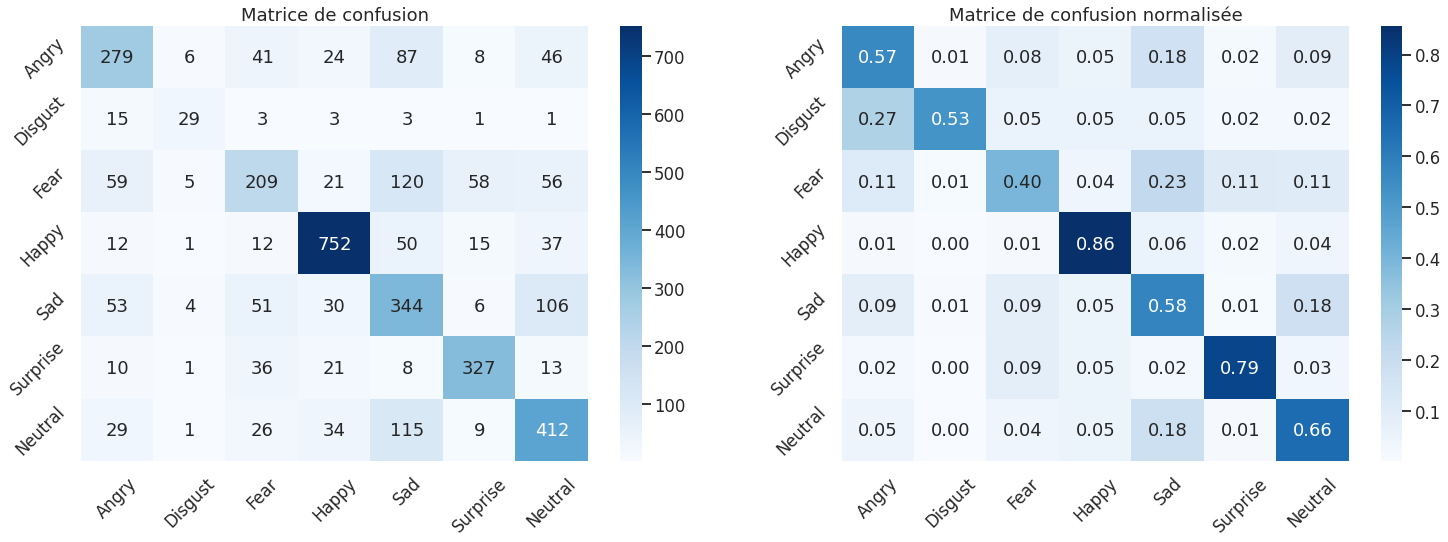

In [18]:
from sklearn.metrics import confusion_matrix
def matrice(test_true, test_pred):
  fig, ax = plt.subplots(1,2, figsize=(25,8))
  matrix = confusion_matrix(test_true, test_pred)
  sns.heatmap(matrix , annot=True,cmap='Blues',ax=ax[0], fmt="1")
  ax[0].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[0].set_yticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[0].set_title("Matrice de confusion")

  matrix = confusion_matrix(test_true, test_pred,normalize="true")
  sns.heatmap(matrix , annot=True,cmap='Blues',ax=ax[1],fmt=".2f")
  ax[1].set_xticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[1].set_yticklabels(['Angry', 'Disgust',  'Fear',  'Happy',  'Sad',  'Surprise',  'Neutral'],rotation=45)
  ax[1].set_title("Matrice de confusion normalisée")
  plt.show()
  return
matrice(test_true, test_pred)

In [19]:
model.save('emotions.h5')

<h3><strong><em> Conclusion:</em></strong></h3>
<h4> Notre modèle est assez performant sur les émotions neutre, surprise et joyeux.<br> En revanche en ce qui concerne la peur notre modèle ne la trouve qu'une fois sur 3, pour la colère la tristesse et le dégoût une fois sur 2.<h4>

---
---
---

<h3><strong><em>On va effectuer une data augmentation sur les emotions les moins performantes puis réentrainer notre modèle et voir si les performances évolues.</em></strong><h3>

In [20]:
data= pd.read_csv('/content/drive/MyDrive/fer2013.csv')

data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()

data_train= augmentation_data(data_train,1,6) #Disgust
data_train= augmentation_data(data_train,2,1) #Fear
data_train= augmentation_data(data_train,4,1) #Sad

data_val= augmentation_data(data_val,1,6) #Disgust
data_val= augmentation_data(data_val,2,1) #Fear
data_val= augmentation_data(data_val,4,1) #Sad

train_X, train_Y = CRNO(data_train, "train") #normalisation
val_X, val_Y     = CRNO(data_val, "val") #validation data

train _X shape: (40252, 48, 48, 1),  train _Y shape: (40252, 7)
val _X shape: (5074, 48, 48, 1),  val _Y shape: (5074, 7)


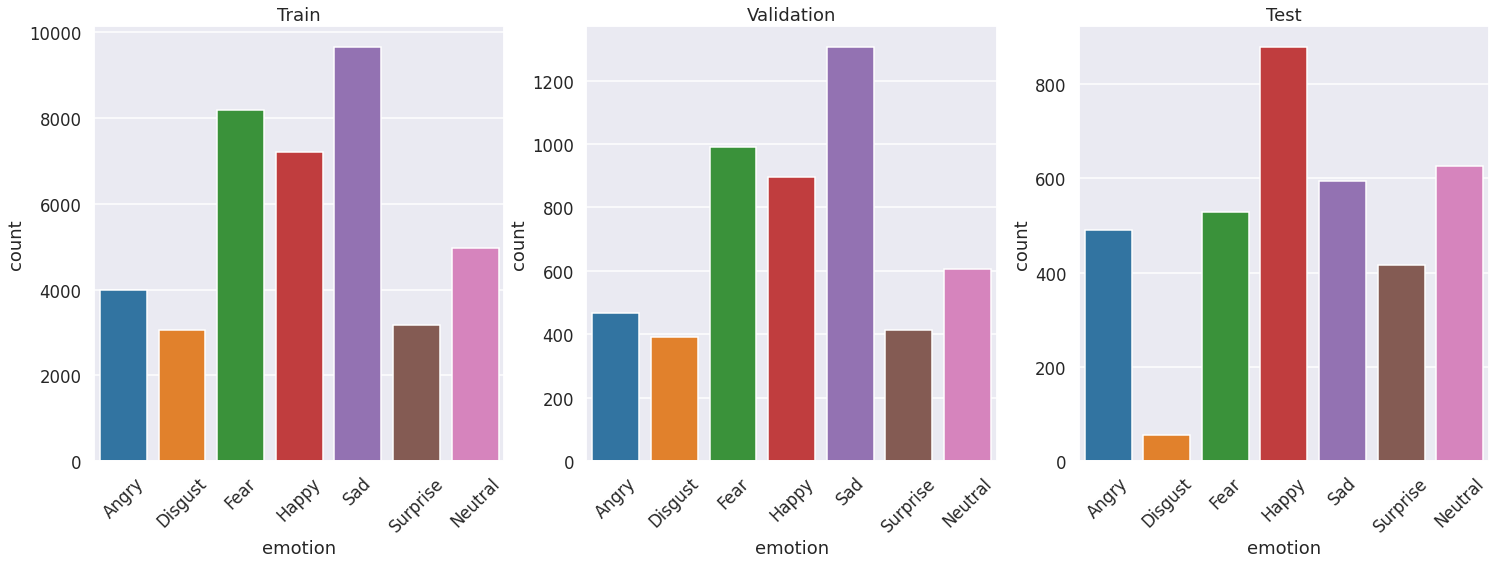

In [21]:
affichage_datas()

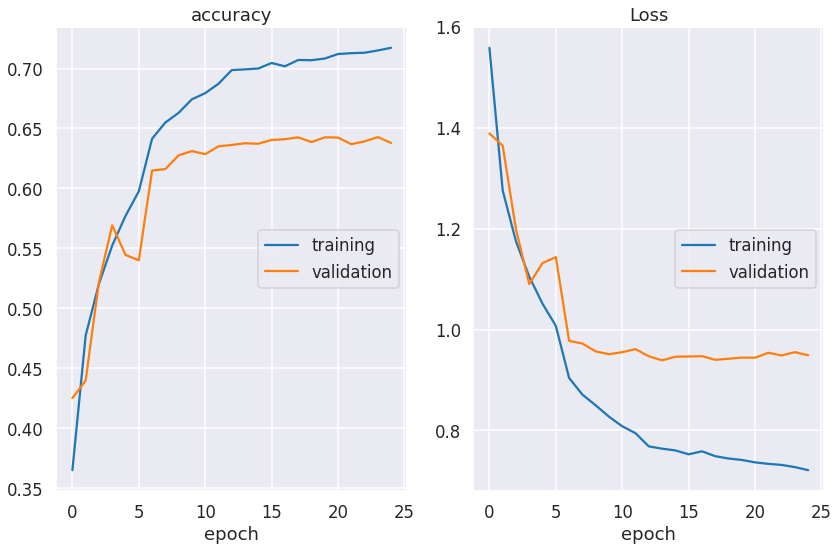

accuracy
	training         	 (min:    0.365, max:    0.717, cur:    0.717)
	validation       	 (min:    0.425, max:    0.643, cur:    0.638)
Loss
	training         	 (min:    0.721, max:    1.558, cur:    0.721)
	validation       	 (min:    0.939, max:    1.389, cur:    0.949)

Epoch 25: saving model to model_weights.h5
628/628 [==============================] - 19s 30ms/step - loss: 0.7212 - accuracy: 0.7173 - val_loss: 0.9490 - val_accuracy: 0.6379 - lr: 1.0000e-05


In [22]:
model = train_model(config_model())

In [23]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 1s 5ms/step
CNN Model Accuracy on test set: 0.6645


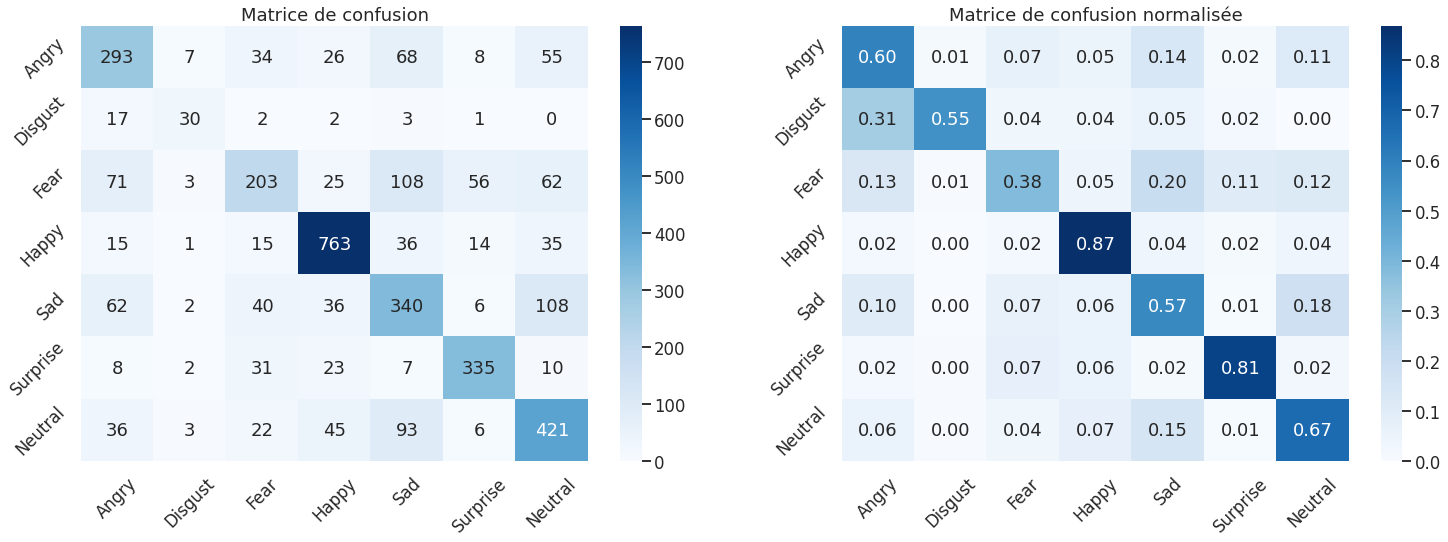

In [24]:
matrice(test_true, test_pred)

In [26]:
model.save('emotions_aug.h5')

<h3><strong><em>Avec la data augmentation nous avons un modèle plus perfomrant avec un accuracy passant de  0.6553 à 0.6645 et nous pouvons également voir que la perte (l'erreur) est plus faible.</em></strong><h3>

<h3><strong><em>Nous pouvons maintenant tester notre modèle dans une application qui testera l'emotion en temps réel des visages présent sur une webcam...</em></strong><h3>